In [538]:
import pandas as pd
import numpy as np

In [539]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

**Data Cleaning**

In [540]:
df_baseball = pd.read_csv("Hitters.csv")

In [541]:
df_baseball.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


We have missing data in the salary column. There are several routes we could take here. If we really prioritized each data point, and we assumed that the NAs in salary are randomly distributed in the population, we could treat the observations with missing salaries as the test data and fit the model on the other data.

However, in this case, we want to tune our model using GridSearch() so we want to remove all NAs, because cross-validation uses all points from our dataset as training and test data.

In [542]:
df_baseball["Salary"].isna().sum()

59

In [543]:
# I am aware I am dropping 59 observations with dropna().

df_baseball = df_baseball.dropna(subset=["Salary"])
len(df_baseball)

263

**Part I: Different Model Specs**

A. Regression without regularization

In [544]:
X = df_baseball.drop("Salary", axis = 1)
y = df_baseball["Salary"]

In [545]:
def roee_pipeline(model=LinearRegression()):
  """
  Creates a pipeline that dummifies the categorical variables and standardizes the numerical.
  
  Parameters
  ----------
  model: a sci-kit learn function
    model specification
    
  Return
  ------
  fit pipeline
  """

  ct = ColumnTransformer(
    [
      ("dummify", 
      OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
      make_column_selector(dtype_include=object)),
      ("standardize", 
      StandardScaler(), 
      make_column_selector(dtype_include=np.number))
    ],
    remainder = "drop"
  )

  pipeline = Pipeline(
    [("preprocessing", ct),
    ("model", model)])
    
  return pipeline

In [546]:
def get_coefficients(dataset, model=LinearRegression()):
  """
  Creates a pipeline that dummifies the categorical variables and standardizes the numerical.
  
  Parameters
  ----------
  model: a sci-kit learn function
    model specification
    
  Return
  ------
  coefficients
  """
  X = dataset.drop("Salary", axis = 1)
  y = dataset["Salary"]
  
  ct = ColumnTransformer(
    [
      ("dummify", 
      OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
      make_column_selector(dtype_include=object)),
      ("standardize", 
      StandardScaler(), 
      make_column_selector(dtype_include=np.number))
    ],
    remainder = "passthrough"
  )

  pipeline = Pipeline(
    [("preprocessing", ct),
    ("model", model)]).set_output(transform="pandas")

  pipeline_fit = pipeline.fit(X, y)
  coefficients = pipeline.named_steps['model'].coef_
  var_names = ct.fit_transform(X).columns

  df_coef = pd.DataFrame({
    "Predictor": var_names,
    "Coefficient": coefficients
  }).sort_values(by="Coefficient", ascending=False)

  return df_coef

In [547]:
get_coefficients(dataset=df_baseball).head(n=3)

,Predictor,Coefficient
13,standardize__CRuns,480.747135
4,standardize__Hits,337.830479
14,standardize__CRBI,260.689886


In [548]:
df_baseball["CRuns"].std()

331.19857059564885

In [549]:
df_baseball["Hits"].std()

45.12532592258135

In [550]:
df_baseball["CRBI"].std()

323.3676681827309

Career runs, hits in the previous season, and career RBIs are the most significant coefficients by magnitude. 

One standard deviation increase in career runs, 331, is associated with an average increase of $480,000 in salary, holding all other variables constant.

One standard deviation increase in hits from the previous season, 45, is associated with an average increase of $337,000 in salary, holding all other variables constant.

One standard deviation increase in career RBIs, 323, is associated with an average increase of $260,000 in salary, holding all other variables constant.

In [551]:
linear_pipeline = roee_pipeline()
cross_val_score(linear_pipeline, X, y, cv = 5, scoring = "neg_mean_squared_error").mean() * -1

121136.31031816879

B. Ridge Regression

In [552]:
def grid_search_df(dataset, pipeline, model = "ridge"):
  """
  Tunes the model and outputs a Data Frame
  
  Parameters
  ----------
  pipeline: a sci-kit learn Pipeline object
  
  model: str
  can be "linear", "ridge", "lasso", "elastic"

  dataset: pandas Data Frame
    
  Return
  ------
  coefficients
  """
  X = dataset.drop("Salary", axis = 1)
  y = dataset["Salary"]

  if model == "elastic":
    alphas = {
    'model__l1_ratio': [0.2, 0.4, 0.6, 0.8],
    'model__alpha': [0.01, 0.1, 1, 10]
    }
  
  else:
    alphas = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10]
    }

  gscv = GridSearchCV(pipeline, alphas, cv=5, scoring='neg_mean_squared_error')

  gscv_fitted = gscv.fit(X, y)

  params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
  results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])

  results_df["scores"] = results_df["scores"] * -1
  return results_df.sort_values(by="scores", ascending=True)

In [553]:
ridge_pipeline = roee_pipeline(model=Ridge())
df_tuned_ridge = grid_search_df(pipeline=ridge_pipeline, model="ridge", dataset=df_baseball)
df_tuned_ridge

,model__alpha,scores
3,1.000,119034.332720
4,10.000,119073.956166
2,0.100,120329.936014
1,0.010,121021.508944
0,0.001,121124.318914


2. The chosen lambda is 1.

In [554]:
ridge_coef = get_coefficients(dataset=df_baseball, model=Ridge(alpha=1))
ridge_coef.head(n=4)

,Predictor,Coefficient
13,standardize__CRuns,320.802717
4,standardize__Hits,296.801967
14,standardize__CRBI,160.409497
11,standardize__CHits,126.210585


Career runs, hits in the previous season, and career RBIs are the most significant coefficients by magnitude. 

One standard deviation increase in career runs, 331, is associated with an average increase of $320,000 in salary, holding all other variables constant.

One standard deviation increase in hits from the previous season, 45, is associated with an average increase of $296,000 in salary, holding all other variables constant.

One standard deviation increase in career RBIs, 323, is associated with an average increase of $160,000 in salary, holding all other variables constant.

4. With the tuning procedure on this data using Ridge Regression, the lowest MSE (with a lambda value of 0.1) is 119,034.33.

C. Lasso Regression

In [555]:
lasso_pipeline = roee_pipeline(model=Lasso(max_iter=100000))
df_tuned_lasso = grid_search_df(pipeline=lasso_pipeline, model="lasso", dataset=df_baseball)
df_tuned_lasso

,model__alpha,scores
3,1.000,119758.108873
2,0.100,120758.508162
1,0.010,121096.159270
0,0.001,121132.276754
4,10.000,121828.141333


2. The best lambda is 1.

In [556]:
lasso_coef = get_coefficients(dataset=df_baseball, model=Lasso(alpha=1))
lasso_coef.head(n=4)

,Predictor,Coefficient
13,standardize__CRuns,375.565519
4,standardize__Hits,304.359509
14,standardize__CRBI,192.610892
8,standardize__Walks,120.695275


Career runs, hits in the previous season, and career RBIs are the most significant coefficients by magnitude. 

One standard deviation increase in career runs, 331, is associated with an average increase of $375,000 in salary, holding all other variables constant.

One standard deviation increase in hits from the previous season, 45, is associated with an average increase of $304,000 in salary, holding all other variables constant.

One standard deviation increase in career RBIs, 323, is associated with an average increase of $192,000 in salary, holding all other variables constant.

4. With the tuning procedure on this data using Lasso Regression, the lowest MSE (with a lambda value of 0.1) is 119,034.33.

D. Elastic Net

In [557]:
elastic_pipeline = roee_pipeline(model=ElasticNet(max_iter=100000))
df_tuned_elastic = grid_search_df(pipeline=elastic_pipeline, model="elastic", dataset=df_baseball)
df_tuned_elastic.head(n=3)

,model__alpha,model__l1_ratio,scores
7,0.10,0.8,118750.189196
0,0.01,0.2,118836.651842
1,0.01,0.4,118936.657888


2. The best lambda is 0.1 and the best alpha is 0.8 for an MSE of 118,750.

In [558]:
elastic_coef = get_coefficients(dataset=df_baseball, model=ElasticNet(alpha=0.1, l1_ratio=0.8))
elastic_coef.head(n=5)

,Predictor,Coefficient
4,standardize__Hits,200.830729
13,standardize__CRuns,163.907498
11,standardize__CHits,110.173426
14,standardize__CRBI,104.504476
8,standardize__Walks,97.341332


In [559]:
df_baseball["CHits"].std()

648.1996437306398

Career runs, hits in the previous season, and career hits are the most significant coefficients by magnitude in this model.

One standard deviation increase in hits from the previous season, 45, is associated with an average increase of $200,000 in salary, holding all other variables constant.

One standard deviation increase in career runs, 331, is associated with an average increase of $163,000 in salary, holding all other variables constant.

One standard deviation increase in career hits, 648, is associated with an average increase of $110,000 in salary, holding all other variables constant.

4. With the tuning procedure on this data using an Elastic Net, the lowest MSE (with a lambda value of 0.1 and alpha of 0.8) is 118,750.19.

**Part II. Variable Selection**

I have determined career runs to be the most important numeric variable in a player's salary in 1987.

I have determined that the five most important numeric variables are as follows:
- Career Runs
- Hits in 1986
- Career Hits
- Career RBIs
- At Bats in 1986

I have determined that the most important categorical variable is Division.

1. Using only the best numeric variable

In [560]:
df_baseball_best_numeric = df_baseball[["CRuns", "Salary"]]

In [561]:
# Linear Regression

X = df_baseball_best_numeric.drop("Salary", axis = 1)
y = df_baseball_best_numeric["Salary"]

linear_pipeline = roee_pipeline()
cross_val_score(linear_pipeline, X, y, cv = 5, scoring = "neg_mean_squared_error").mean() * -1

143812.9359162973

In [562]:
linear_coef = get_coefficients(dataset=df_baseball_best_numeric)
linear_coef

,Predictor,Coefficient
0,standardize__CRuns,253.351392


In [563]:
# Ridge Regression

ridge_pipeline = roee_pipeline(model=Ridge())
df_tuned_ridge = grid_search_df(pipeline=ridge_pipeline, model="ridge", dataset=df_baseball_best_numeric)
df_tuned_ridge.head(n=1)

,model__alpha,scores
4,10.0,143658.517369


In [564]:
ridge_coef = get_coefficients(dataset=df_baseball_best_numeric, model=Ridge())
ridge_coef

,Predictor,Coefficient
0,standardize__CRuns,252.391728


In [565]:
# Lasso Regression

lasso_pipeline = roee_pipeline(model=Lasso())
df_tuned_lasso = grid_search_df(pipeline=lasso_pipeline, model="lasso", dataset=df_baseball_best_numeric)
df_tuned_lasso.head(n=1)

,model__alpha,scores
4,10.0,143793.449159


In [566]:
elastic_pipeline = roee_pipeline(model=ElasticNet(max_iter=100000))
df_tuned_elastic = grid_search_df(pipeline=elastic_pipeline, model="elastic", dataset=df_baseball_best_numeric)
df_tuned_elastic.head(n=1)

,model__alpha,model__l1_ratio,scores
5,0.1,0.4,143660.021761


The MSE's on the tuned models for the best numeric are as follows:
- Regression without regularization: 143812.94
- Ridge(Lambda=10): 143658.52
- Lasso(Lambda=10): 143793.45
- Elastic Net(Lambda=0.1, Alpha=0.2): 143660.02

Ridge Regression performs the best, but Elastic Net and Lasso are all incredibly similar. This model is inherently flawed because one predictor variable does not give us a lot of information.

2. Using only the five best variables.

In [567]:
df_baseball_five = df_baseball[["CRuns", "Hits", "CHits", "CRBI", "AtBat", "Salary"]]

In [568]:
# Linear Regression

X = df_baseball_five.drop("Salary", axis = 1)
y = df_baseball_five["Salary"]

linear_pipeline = roee_pipeline()
cross_val_score(linear_pipeline, X, y, cv = 5, scoring = "neg_mean_squared_error").mean() * -1

123972.91619275289

In [569]:
# Ridge Regression

ridge_pipeline = roee_pipeline(model=Ridge())
df_tuned_ridge = grid_search_df(pipeline=ridge_pipeline, model="ridge", dataset=df_baseball_five)
df_tuned_ridge.head(n=1)

,model__alpha,scores
3,1.0,123314.761609


In [570]:
# Lasso Regression

lasso_pipeline = roee_pipeline(model=Lasso())
df_tuned_lasso = grid_search_df(pipeline=lasso_pipeline, model="lasso", dataset=df_baseball_five)
df_tuned_lasso.head(n=1)

,model__alpha,scores
2,0.1,123952.547214


In [571]:
elastic_pipeline = roee_pipeline(model=ElasticNet(max_iter=100000))
df_tuned_elastic = grid_search_df(pipeline=elastic_pipeline, model="elastic", dataset=df_baseball_five)
df_tuned_elastic.head(n=1)

,model__alpha,model__l1_ratio,scores
0,0.01,0.2,123191.112297


The test scores are improving! The MSE's on the tuned models for the five best numerics are as follows:

- Regression without regularization: 123972.92
- Ridge(Lambda=1): 123314.76
- Lasso(Lambda=0.1): 123952.55
- Elastic Net(Lambda=0.01, Alpha=0.2): 123191.11

The best model now is Elastic Net with the above parameters. 

3. Using the five best numeric variables and their interactions with the one best categorical variable.

In [572]:
X = df_baseball.drop("Salary", axis = 1)
y = df_baseball["Salary"]

In [573]:
# Column Transformers for interaction

ct_pre = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, drop="first"), ["Division"]),
    ("standardize", StandardScaler(), ["CRuns", "Hits", "CHits", 
                                       "CRBI", "AtBat"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
    [
      ("interaction1", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__Division_W", "standardize__CRuns"]),
      ("interaction2", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__Division_W", "standardize__Hits"]),
      ("interaction3", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__Division_W", "standardize__CHits"]),
      ("interaction4", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__Division_W", "standardize__CRBI"]),
      ("interaction5", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__Division_W", "standardize__AtBat"])
    ]
).set_output(transform="pandas")

In [574]:
# Linear Regression without Regularization

linear_pipeline = Pipeline(
  [("preprocessing", ct_pre),
   ("interaction", ct_inter),
  ("model", LinearRegression())]
).set_output(transform="pandas")

cross_val_score(linear_pipeline, X, y, cv = 5, scoring = "neg_mean_squared_error").mean() * -1

127803.44470976581

In [575]:
# Ridge Regression

ridge_pipeline = Pipeline(
  [("preprocessing", ct_pre),
   ("interaction", ct_inter),
  ("model", Ridge())]
).set_output(transform="pandas")

df_tuned_ridge = grid_search_df(pipeline=ridge_pipeline, model="ridge", dataset=df_baseball)
df_tuned_ridge.head(n=1)

,model__alpha,scores
4,10.0,121472.320745


In [576]:
# Lasso Regression

lasso_pipeline = Pipeline(
  [("preprocessing", ct_pre),
   ("interaction", ct_inter),
  ("model", Lasso(max_iter=1000000))]
).set_output(transform="pandas")

df_tuned_lasso = grid_search_df(pipeline=lasso_pipeline, model="lasso", dataset=df_baseball)
df_tuned_lasso.head(n=1)

,model__alpha,scores
4,10.0,123676.132348


In [577]:
# Elastic Net Regression

elastic_pipeline = Pipeline(
  [("preprocessing", ct_pre),
   ("interaction", ct_inter),
  ("model", ElasticNet(max_iter=1000000))]
).set_output(transform="pandas")

df_tuned_elastic = grid_search_df(pipeline=elastic_pipeline, model="elastic", dataset=df_baseball)
df_tuned_elastic.head(n=1)

,model__alpha,model__l1_ratio,scores
4,0.1,0.2,121281.565485


The MSE's on the tuned models for the best numeric are as follows:

- Regression without regularization: 127803.44
- Ridge(Lambda=10): 121472.32
- Lasso(Lambda=10): 123676.13
- Elastic Net(Lambda=0.01, Alpha=0.2): 121281.57

The best model is Elastic Net with the above parameters. 

**Part 3: Discussion**

A. Ridge

The coefficients on my ridge regression are smaller than those on my ordinary regression models when we are using the full dataset. This is because ridge regression places a penalty on coefficient size to provide a balance between overfitting and underfitting.

B. LASSO

I did not get the same lambda parameters for the different LASSO models I created. There are several reasons for that. Lasso uses a penalty term to prevent overfitting by shrinking coefficient magnitudes towards zero. 

The parameter with the full dataset is 1. It is 10 with the best numeric variable. It is 0.1 with the five best numeric variables and it is 10 again with the five best numeric variables and there interactions.

This makes sense because each of these models have a different amount of variables, so the lambda parameter functions differently to fit these datasets and prevent overfitting.

The MSEs are very similar across all four models, not including the model with solely the best numeric variable. This makes sense because LASSO emphasizes the most important coefficients in the first dataset and we chose those most important coefficients to model in Part II. 

C. Elastic Net

Elastic Net often "wins" because it combines the flexibility of Ridge and LASSO regression when it comes to dealing with overfit models. We can tune the model now on both lambda and alpha, creating a model that should be at least as good as one of the Ridge or Lasso regressions run before it.

**Part 4: Final Model**

My best model came in the beginning, interestingly enough, with all of the variables and using Elastic Net. I might not have picked the most significant variables in the model and that caused the models in Part II to lack the significance needed to beat model 1. Regardless, this is the best model I created during this lab:

In [578]:
elastic_pipeline = roee_pipeline(model=ElasticNet(max_iter=100000))
df_tuned_elastic = grid_search_df(pipeline=elastic_pipeline, model="elastic", dataset=df_baseball)
df_tuned_elastic.head(n=1)

,model__alpha,model__l1_ratio,scores
7,0.1,0.8,118750.189196


This model has a MSE of 118750.19.

In [590]:
elastic_df = get_coefficients(dataset=df_baseball, model=ElasticNet(alpha=0.1, l1_ratio=0.8))

elastic_df["Coefficient_Abs"] = elastic_df["Coefficient"].abs()
elastic_df = elastic_df.sort_values(by="Coefficient_Abs", ascending=False).head(n=6)

In [591]:
elastic_df

,Predictor,Coefficient,Coefficient_Abs
4,standardize__Hits,200.830729,200.830729
3,standardize__AtBat,-186.181515,186.181515
13,standardize__CRuns,163.907498,163.907498
15,standardize__CWalks,-125.175493,125.175493
1,dummify__Division_W,-116.818145,116.818145
11,standardize__CHits,110.173426,110.173426


With this model, I have interpreted the coefficients above, but the most important ones are:
- Hits in 1986
- Career Runs
- Career Hits
- Career RBI

The instructions for making a plot are a little vague. I am going to plot my most important coefficients on a column chart.

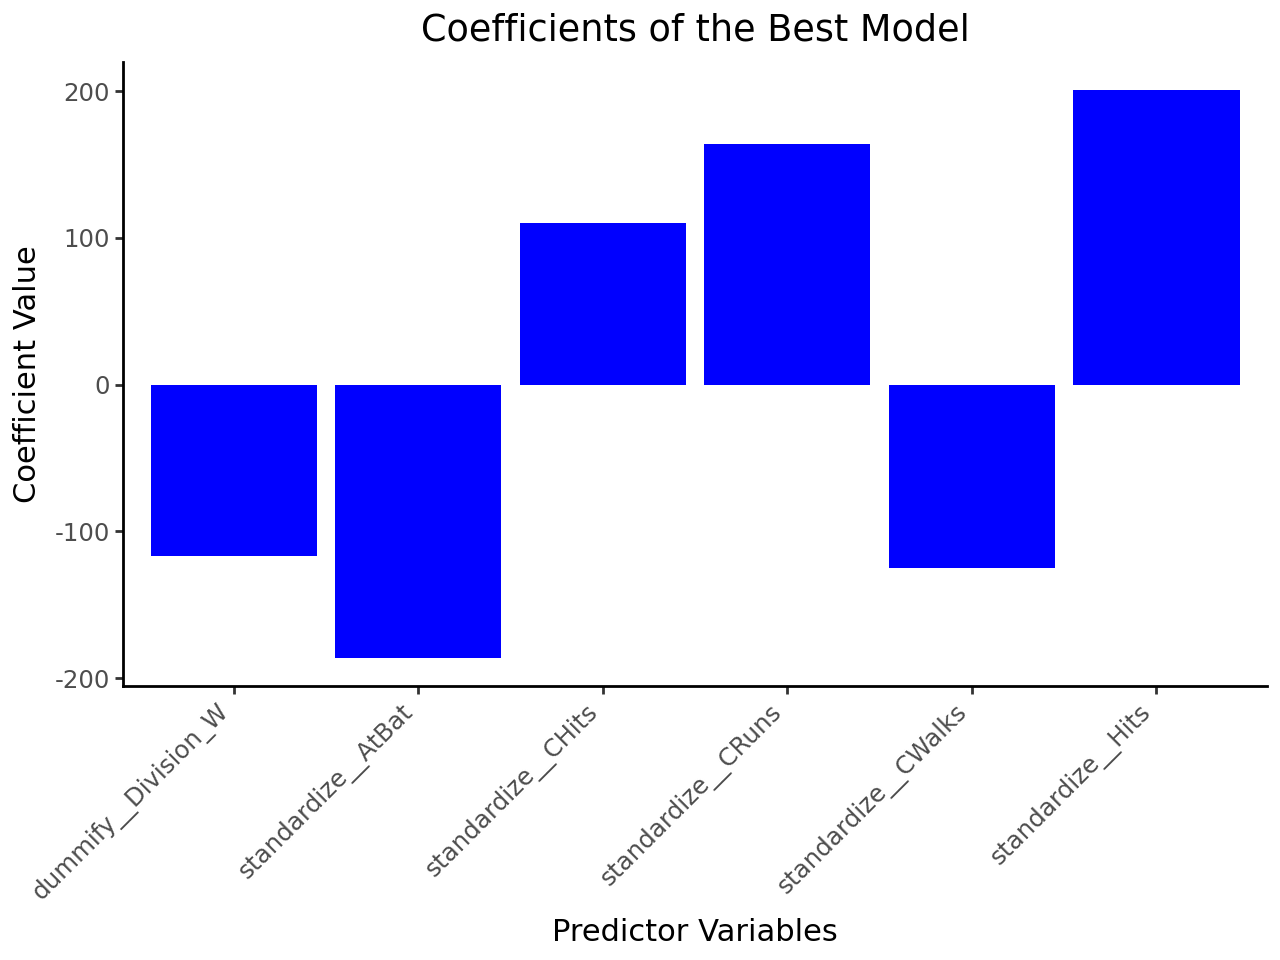

In [597]:
from plotnine import ggplot, aes, geom_bar, labs, theme_classic, theme, element_text

(ggplot(elastic_df, aes(x="Predictor", y="Coefficient")) +
geom_bar(stat="identity", fill="blue") + 
theme_classic() +
theme(axis_text_x=element_text(rotation=45, hjust=1)) +
labs(x="Predictor Variables", y="Coefficient Value", 
     title="Coefficients of the Best Model"))